# Exploration of the Ford GoBike System Data
## by Dmitrij Burlak



## Preliminary Wrangling
Is done in the notebook DownloadAndCleanData.ipynb

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [85]:
%%time
rides_all = pd.read_csv('data/rides.csv');
rides = rides_all.copy()

Wall time: 10.4 s


In [86]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1740396 entries, 0 to 1740395
Data columns (total 20 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           int64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
user_age                   int64
start_daytime              object
end_daytime                object
start_month                int64
dtypes: float64(5), int64(6), object(9)
memory usage: 265.6+ MB


### What is the structure of your dataset?
There are 1740396 rides in the dataset with 19 anonymized features 
- Trip Duration (seconds)
- Start Time and Date
- Start Station ID
- Start Station Name
- Start Station Latitude
- Start Station Longitude


- End Time and Date
- End Station ID
- End Station Name
- End Station Latitude
- End Station Longitude


- Bike ID
- User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)
- Member Year of Birth
- Member Gender

Derived features 
- User Age
- Start Daytime	
- End Daytime	
- Start Month

Most variables are nominal in nature, but the variables duration and age are numeric variables.
The ordinal variable user_type, start_month are ordered with the following levels:

User Type: Customer -> Subscriber

Start/End Daytime: 'morning' ->'afternoon' -> 'evening' -> 'night'

Start Month: 1 -> ... -> 12

### What is/are the main feature(s) of interest in your dataset?

In order to answer our questions of interest: How long does the average trip take? Does this depend on if a user is a subscriber or customer or the location?    

The main features we will focus on to answer the above will be: trip duration, User type, Start day time.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
In order to get detailed insights into the different ride durations we are going to need the support of especially longitude/latitude (extracting location) and  start timestamp (extracting start/end Daytime)  features.  

## Univariate Exploration

In this part we going to look into the distribution of duration, age, gender, type and if a bike was shared during the rides. 

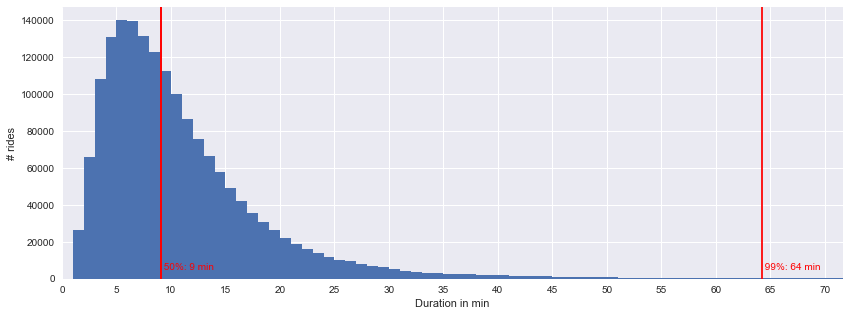

In [87]:
# How long does the average trip take/ start with a standard hist plot of ride duration
binsize = 60
bins = np.arange(0, rides['duration_sec'].max()+binsize, binsize)

plt.figure(figsize=[14, 5])
plt.hist(data = rides, x = 'duration_sec', bins = bins)
plt.xlabel('Duration in min')
xticks = np.arange(0,4000+300, 300)
xticksl= [int(x/60) for x in xticks]
plt.xticks(xticks,xticksl)
plt.xlim(0,4300)
plt.ylabel('# rides')
plt.axvline(rides.duration_sec.median(), color='r')


## The 99% line
uperPercentile = rides.duration_sec.quantile(0.99)
plt.axvline(uperPercentile, color='r')
plt.text(x=uperPercentile, y=5e3, s=' 99%: {} min'.format(int(uperPercentile/60)), color='r')

## The 50% line
median=rides.duration_sec.median()
plt.axvline(median, color='r')
plt.text(x=median, y=5e3, s=' 50%: {} min'.format(int(median/60)), color='r')
plt.show()

The series seems to be strongly right skewed so I'll check for a useful cutoff with percentils.

In [88]:
# duration is strongly right skewed
print(rides.duration_sec.quantile([.01,.25,.5,.99,.999]))

rides.duration_sec.describe()

0.010      106.00
0.250      344.00
0.500      543.00
0.990     3856.00
0.999    27873.42
Name: duration_sec, dtype: float64


count    1.740396e+06
mean     7.728238e+02
std      1.942687e+03
min      6.100000e+01
25%      3.440000e+02
50%      5.430000e+02
75%      8.390000e+02
max      8.628100e+04
Name: duration_sec, dtype: float64

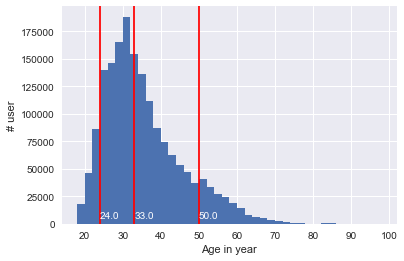

In [89]:
# another hist of age with 10% 50% and 75% quantiles 
bins = np.arange(18,100, 2)
plt.hist(data= rides, x='user_age', bins=bins);
plt.xlabel('Age in year')
plt.ylabel('# user');
quantiles = rides.user_age.quantile([0.1,0.5,0.9])
for q in quantiles.values:
    plt.axvline(q, color = 'r')
    plt.text(x=q, y = 5e3, s = q, color='w')

Around 50 year there seems to be another peek. In order to analyse this observation I'll look more in detail into a violinplot.

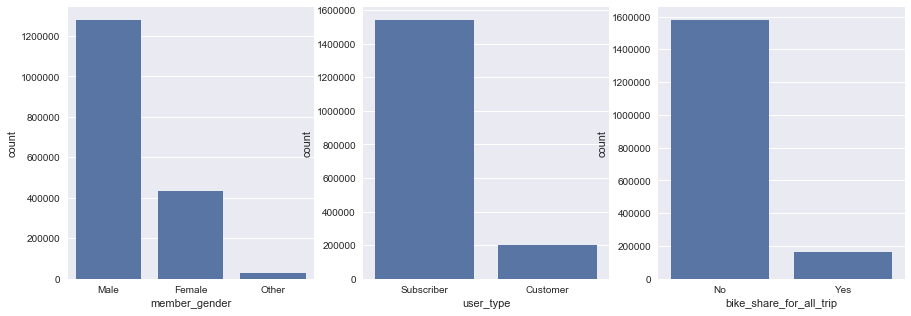

In [90]:
# Look into the categorical variables
plt.figure(figsize = [15,5])

plt.subplot(1, 3,1)
sns.countplot(data=rides, x = 'member_gender', color = sns.color_palette()[0]);

plt.subplot(1,3,2)
sns.countplot(data=rides, x = 'user_type', color = sns.color_palette()[0]);

plt.subplot(1,3,3)
sns.countplot(data=rides, x = 'bike_share_for_all_trip', color = sns.color_palette()[0]);


Most common user seems to be a male subscribtion without sharing the bike for all trip.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
We can see that the distribution for age and duration is strongly right skewed. The distribution of the categorical vars shows that the common user is a male subscriber without sharing the bike for all trip.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

As we could see in the distribution of duration of rides the most rides are taking less then 64 min. The extreme ride durations are though 86281. Because of this big range of values we will focus in further on the 99% of the data. Same for age distribution in further we assume that age over 100 is rather erroneously.

## Bivariate Exploration

In this section we are about to investigate relationships between user type and duration, age and duration as well as between longitude and latitude of a station.

In [91]:
per_99=rides[rides.duration_sec < 3865]
sub=per_99[per_99.user_type == 'Subscriber']
cus=per_99[per_99.user_type == 'Customer']

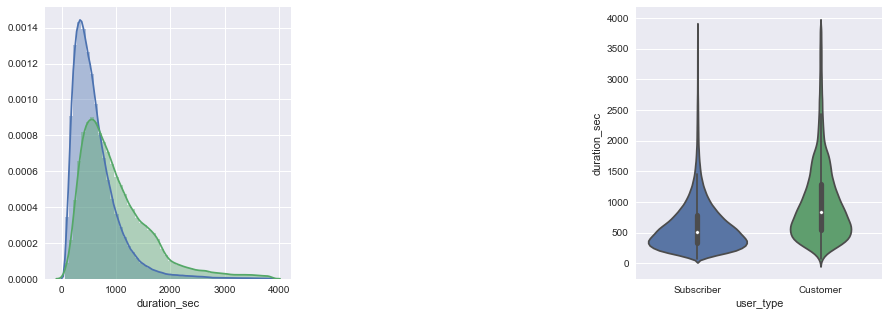

In [92]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.distplot( sub.duration_sec)
sns.distplot( cus.duration_sec)

plt.subplot(1,3,3)
g = sns.violinplot(data=per_99, x='user_type', y='duration_sec')

We can see that the customer user type has in average double time bike ride as the subscriber user type.

Wall time: 3.5 s


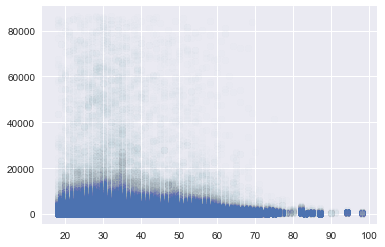

In [93]:
%%time
#duration vs. age
plt.scatter(data=rides, y='duration_sec', x = 'user_age', alpha=0.009);


As expected we observe a slight trend that shows with around 30 the ride duration is higher and decrease with growing age.  

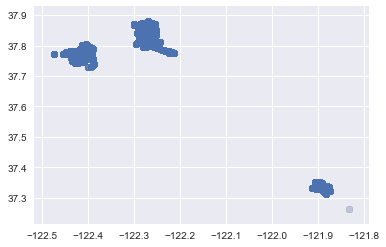

In [94]:
limit=rides[0:40]
plt.scatter(data =rides, y='start_station_latitude' , x='start_station_longitude', alpha=0.01);


Unexpectedly besides the three clusters for the major locations there is also a forth location next to SanJose. In further the identified point is treated as an outlier and will be removed from the data. 

In [95]:
unknownLocDf = rides[rides.start_station_longitude > -121.85]
rides = rides[rides.start_station_longitude < -121.85]

In [96]:
labels = ['SanFran', 'EastBay', 'SanJose']
bins = [-122.5,-122.35,-122.2,-121.85]

rides.loc[:,'location'] = pd.cut(rides.start_station_longitude, bins=bins, labels=labels, include_lowest= True)

Wall time: 5.82 s


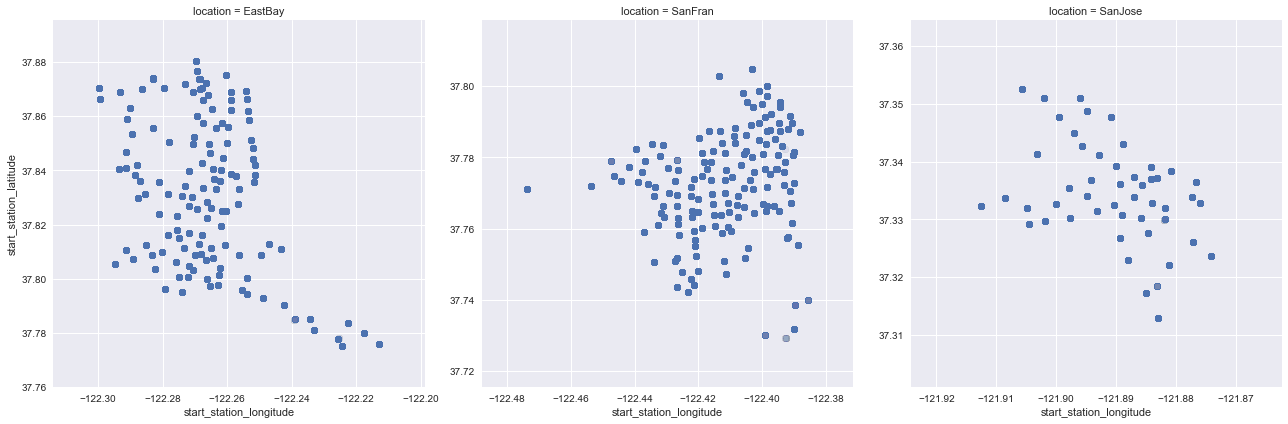

In [97]:
%%time
g = sns.FacetGrid(data=rides, col = 'location', size=6, sharey=False, sharex=False)
g.map(plt.scatter, 'start_station_longitude','start_station_latitude', alpha=0.01 );

Distribution of all stations in every officially supported location shows that the density of the stations is the highest in SanFran. Also we can see which areas are covered less.

In [98]:
# separate cities vs avg duration
rides.groupby('location').duration_sec.mean()

location
EastBay    719.439227
SanFran    794.831811
SanJose    681.910838
Name: duration_sec, dtype: float64

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

We could observe that the duration is different for the different types of user. 
### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We could observe that there is a negative trend between the average duration and the age, where higher age relates stronger to shorter rides. Looking into the longitude/latitude features shows that besides the three expected clusters for each suppported location (San Francisco, East Bay and San Jose)  also a forth cluster next ti San Jose is existent. 

## Multivariate Exploration

In this part we are gong to create plots of three or more variables to investigate development over the year 2018. 
We will look closer into enumeration and frequency of the bike stations as well as durations of a ride in relation to its location.

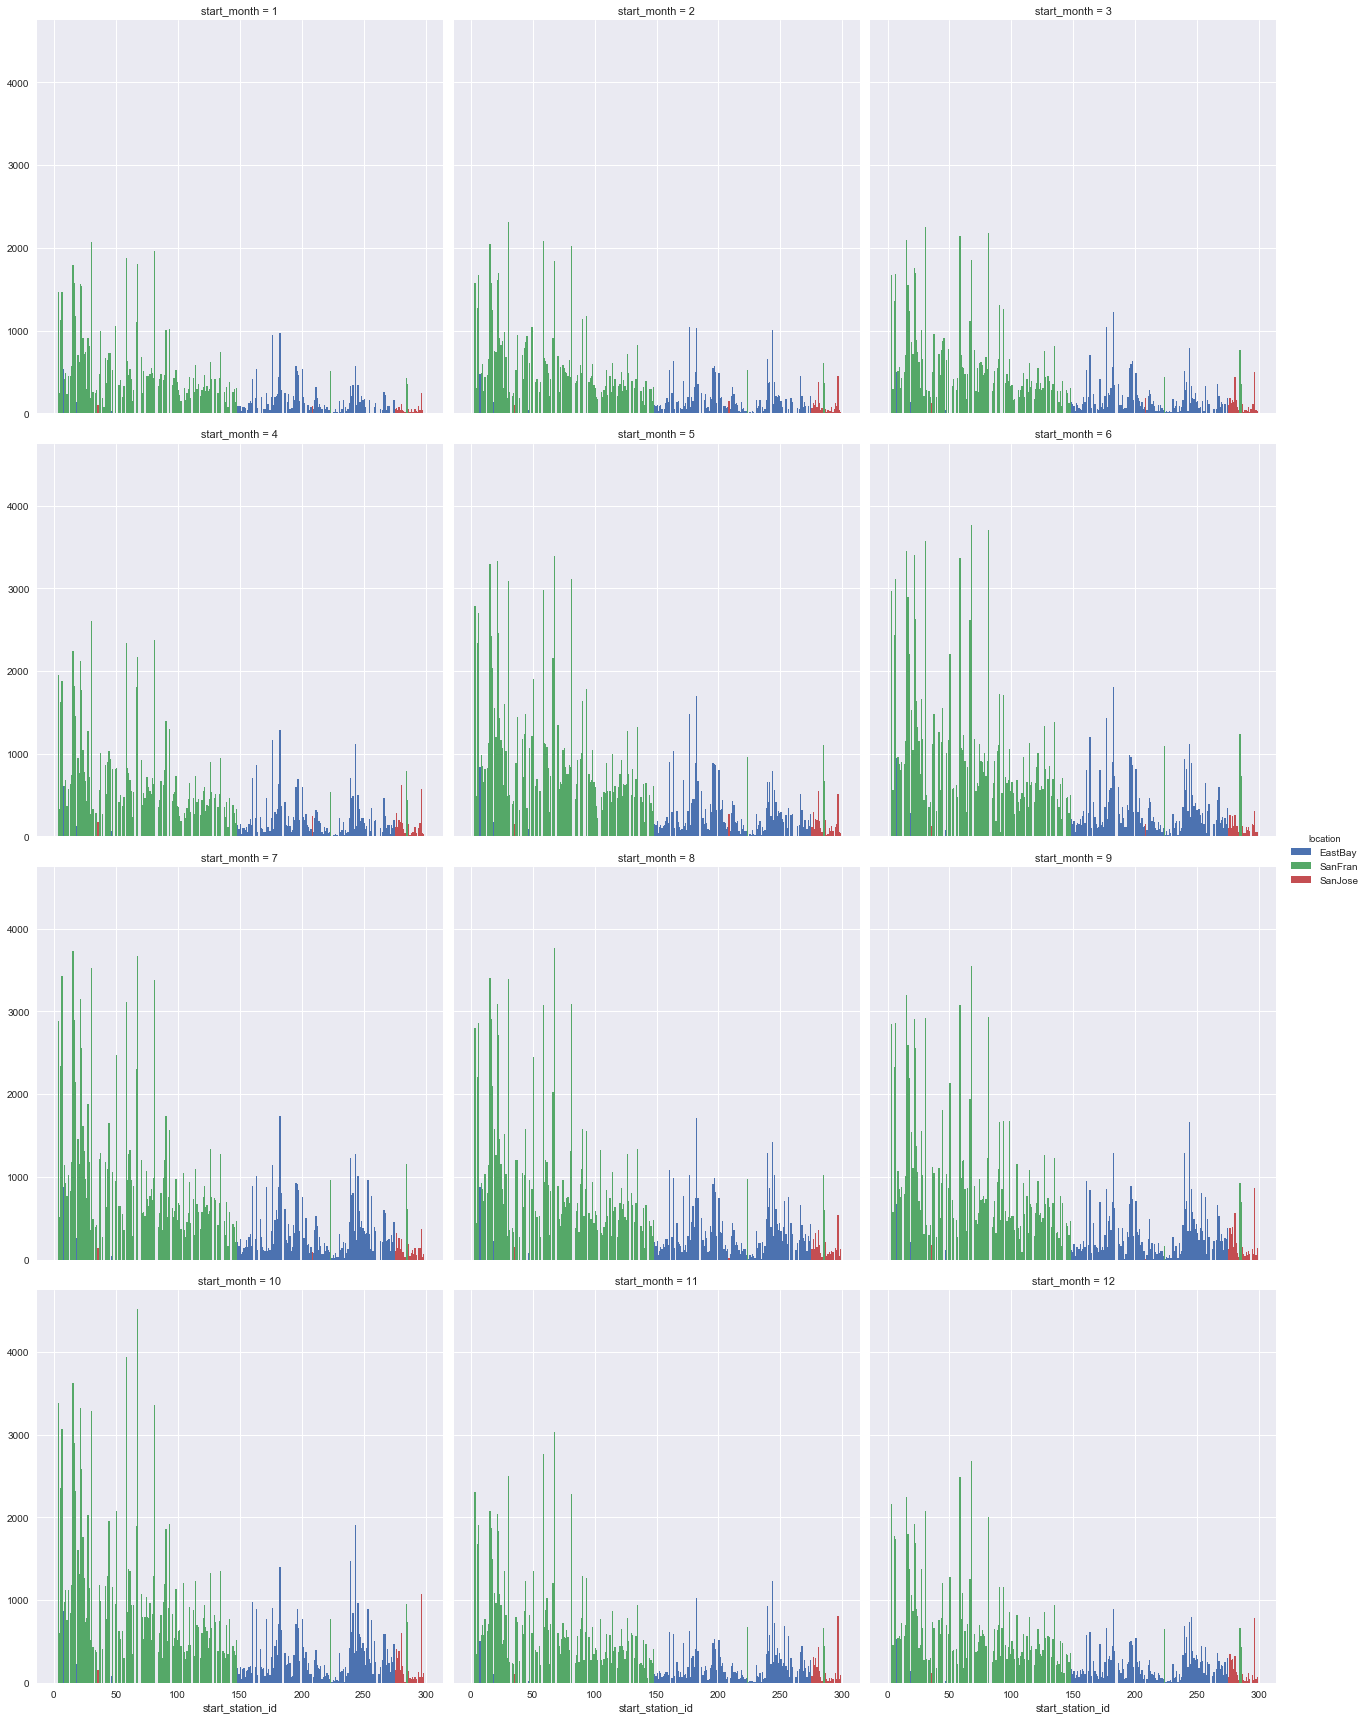

In [99]:
# month vs (start station id counts as hist), separated by location

g = sns.FacetGrid(data = rides, col = 'start_month', col_wrap=3, hue='location',size=6)
g.map(plt.hist, 'start_station_id', bins=np.arange(1,300,1))
g.add_legend()

As we can see the stationIds are mostly assigned linearly first 0 ~ 150 SanFran, 150 ~ 280 EastBay and 280 ~ 300 SanJose.
The amount of rides is growing, independent of location, towards October and is decreasing with the lowest amount of rides  towards January.

In [100]:
#order of locations based on location frequency
hueOrd=rides.location.value_counts().index.values

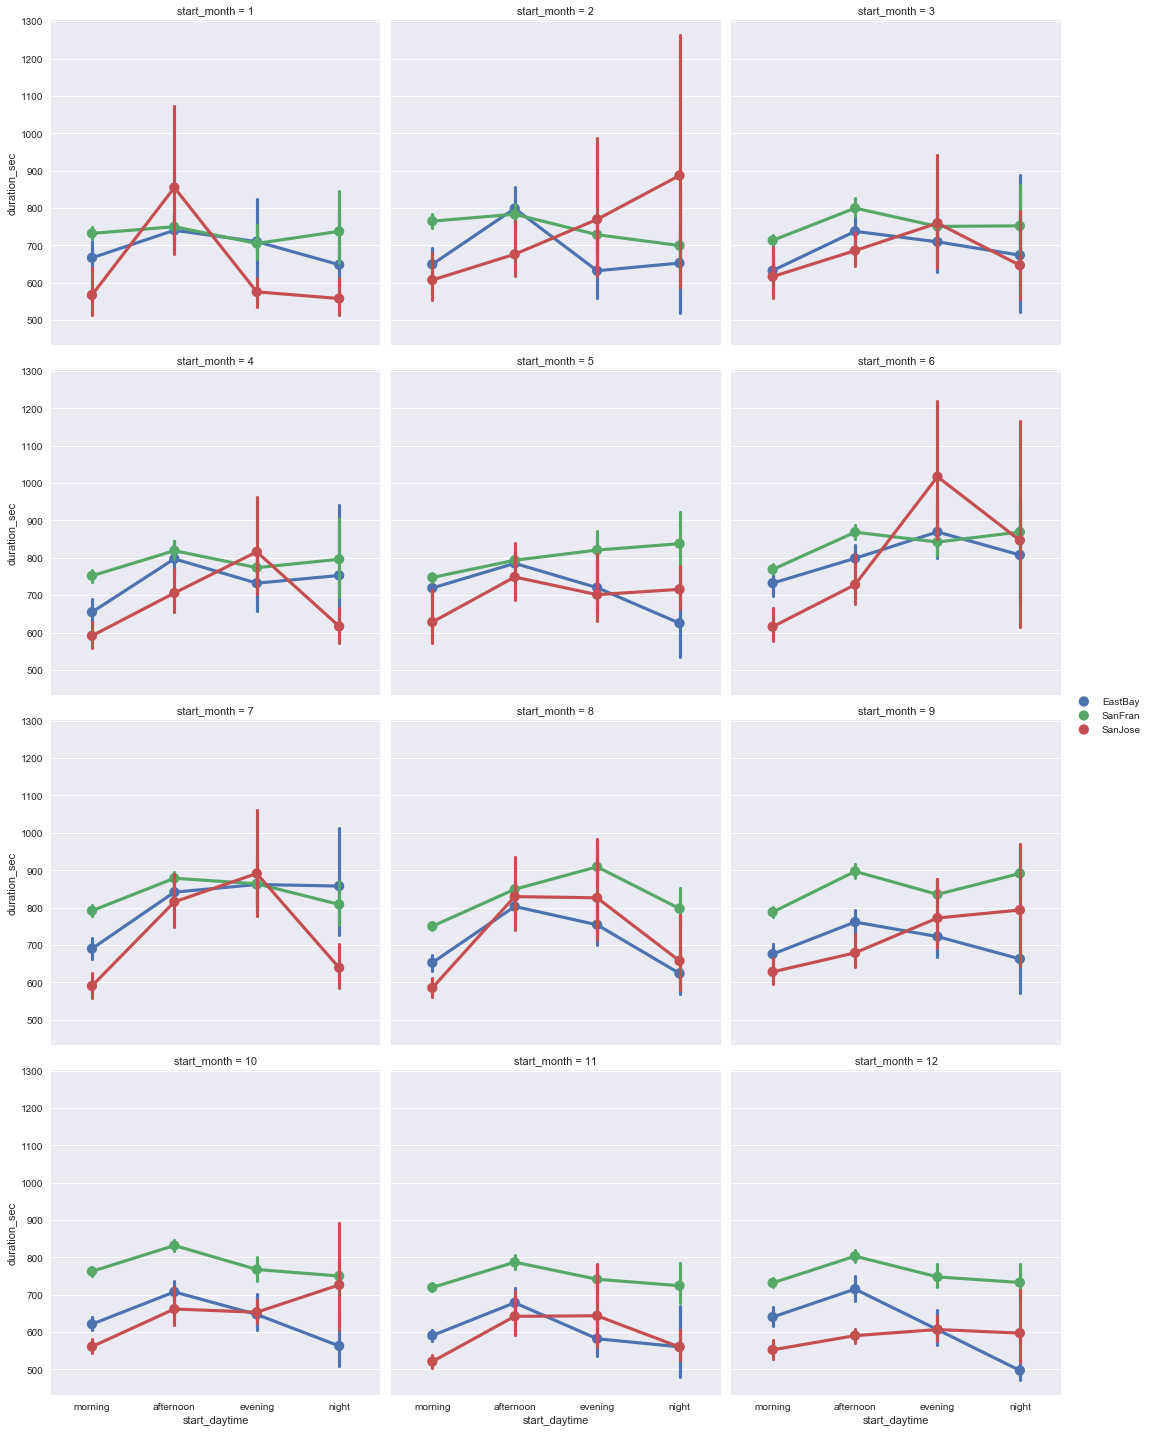

In [104]:
# month vs (start station id counts as hist), separated by location
time_order = ['morning', 'afternoon', 'evening', 'night']

g = sns.FacetGrid(data = rides, col = 'start_month', col_wrap=3, size=5, legend_out=True)
g.map(sns.pointplot, 'start_daytime', 'duration_sec', 'location', order = time_order, palette = sns.color_palette()[0:3])
g.add_legend();

### Relationships we observed in this part of the investigation:

In this part we were investigating the development of several features over the year 2018. We will looked closer into enumeration and frequency of the bike stations as well as durations of a ride in relation to its location. 

### Surprising interactions between features:
Surprisingly we can observe a relationship between the station ids and their locations. The ids are increasing from 0 to 300 and it seems that ids until 150 are mainly in San Francisco the once until 280 are in East Bay and the once until 300 in San Jose. Location independent we can see that the highest usage of the Ford Go Bike system is in October.  

The relation between the frequency and month of the year shows that in October there are the most rides and in January the fewest.

Duration wise the longest average rides are in the East Bay area. Surprisingly the development of the durations during the day is changing for every location almost every month.


In [105]:
rides.to_csv('data/rides_all_explored.csv', index=False);